# SVM and Kernels

### Objective
Through this project, you will learn to use nonlinear kernels to improve a support vector classifier. The toy examples within this project aim to guide you as you build your intuition for the decision boundaries that can be generated via different kernels.

This project is structured as follows:
#### Part 1: Binary classification of synthetic data
1.1. Generate and explore synthetic data

1.2. SVM with nonlinear kernels
#### Part 2: US Flags
2.1. Load and explore flags data

2.2. SVMs for flag pixel data

2.3. Comparison to decision trees


In [48]:
# standard imports
import os, random
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.datasets import *
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay

# you may need to install the PIL in your environment
# for installation in mamba environment type "mamba install pillow -c conda-forge" in your miniforge prompt
# for installation in conda environment type "conda install pillow -c conda-forge" in your conda prompt or anaconda prompt
# for installation via pip type "pip install pillow" in your terminal
from PIL import Image

## Part 1: Binary classification of synthetic data

### Part 1.1: Generate and explore synthetic data
The next cell defines the function `generate_dataset`, which you can use to generate synthetic (i.e., computer generated) data sets for binary classification. It includes eight different methods for data-set generation. 
1. Try out each method and visualize the resulting data set. For the 'swiss' and 'scurve' data sets, try out two different values of the keyword argument `splits`.
2. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a linear classifier.
3. Comment on WHETHER and WHY you anticipate this data set to be relatively easy or relatively hard to classify with a nonlinear classifier.

In [49]:
# Function to convert an array of real numbers into an array of 0s and 1s
def binarize(arr, split=10):
    # Calculate the decile thresholds
    percentiles = int(np.ceil(100/split))
    split_points = np.arange(0, 100+percentiles, percentiles)
    split_points[split_points>100] = 100
    deciles = np.percentile(arr, split_points)
    
    # Create a new array to hold the modified values
    modified_arr = np.zeros_like(arr)
    
    # Iterate through each decile range and set values accordingly
    for i in range(split):
        # print(i)
        if i == split-1:
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i])] = 1
        else:        
            if i % 2 == 0:
                # Set values in even deciles to 0
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 0
            else:
                # Set values in odd deciles to 1
                modified_arr[(arr >= deciles[i]) & (arr < deciles[i + 1])] = 1
    
    return modified_arr

# Function to generate datasets
def generate_dataset(dataset_type, n_samples=300, noise=0.1, split=10, random_state=0):
    if dataset_type == 'linearly_separable':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                                   random_state=random_state, n_clusters_per_class=1)
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=[n_samples//2, n_samples//2], random_state=random_state, cluster_std=noise)
    elif dataset_type == 'quantiles':
        X, y = make_gaussian_quantiles(n_samples=n_samples, n_classes=2, cov=noise, random_state=random_state)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=random_state)
    elif dataset_type == 'unstructured':
        X, y = np.random.random(size=(n_samples, 2)), np.random.randint(0,2, size=(n_samples))
    elif dataset_type == 'swiss':
        X, y = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    elif dataset_type == 'scurve':
        X, y = make_s_curve(n_samples=n_samples, noise=noise, random_state=random_state)
        X=np.array([X[:,0],X[:,2]]).T
        y = binarize(y, split=split)
    else:
        raise ValueError("Invalid dataset type")
    
    X = StandardScaler().fit_transform(X)
    return X, y

In [50]:
def plot_dataset(type, name, split = 10):
    X, y = generate_dataset(type, split = split)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1')
    plt.title(name)
    plt.show()

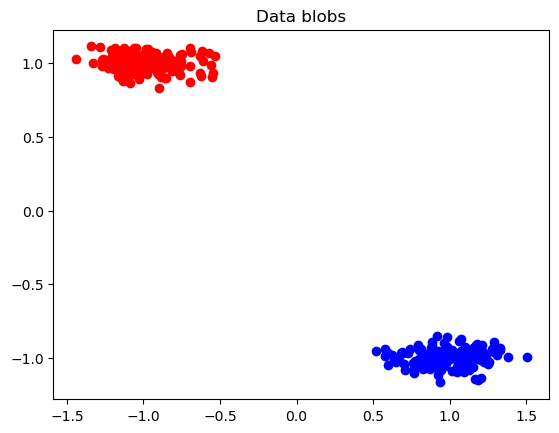

In [51]:
# Generate and visualize data blobs
plot_dataset('blobs', 'Data blobs')

I anticipate that this data set is linearly separable since we can very easily note that a line `y = x` separates both clusters. Since the data is so nicely clustered, it looks like for any `n` there is a `n`-degree polynomial that would separate them.

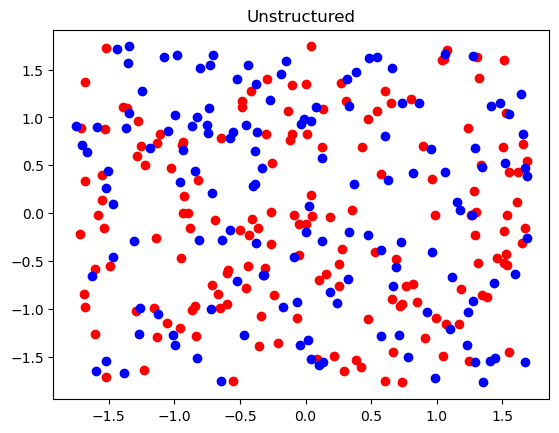

In [52]:
# Generate and visualize unstructured data
plot_dataset('unstructured', 'Unstructured')

It's very clear that this data set cannot be classified by neither a linear nor a non-linear classifier since the color of each datapoint seems completely random. Any error-free classifer would be horribly overfit.

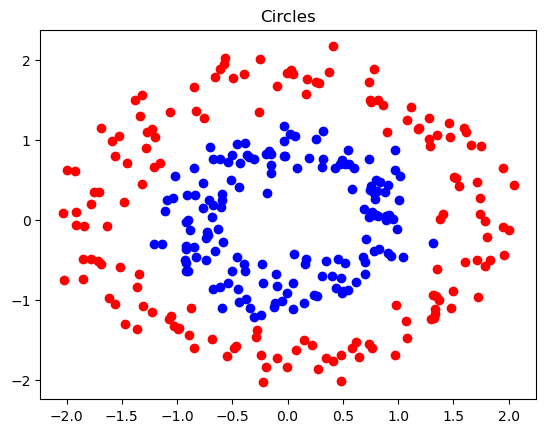

In [53]:
# Generate and visualize circles data set
plot_dataset('circles', 'Circles')

It's clear that no line will be able to separate these two clusters successfully. However, a non-linear classifer would be able to separate these two kinds of datapoints. In fact, a degree `2` polynomial on `R^2` centered at the origin with the unit circle as its roots would be very close to being the ideal classifier.

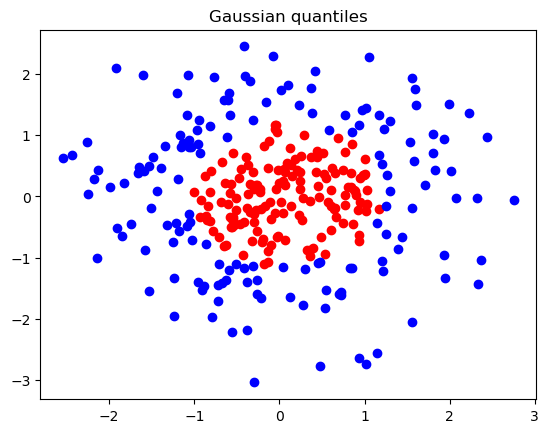

In [54]:
# Generate and visualize Gaussian quantiles
plot_dataset('quantiles', 'Gaussian quantiles')

This is essentially the same scenario as before. A degree `2` polynomial on `R^2` should suffice.

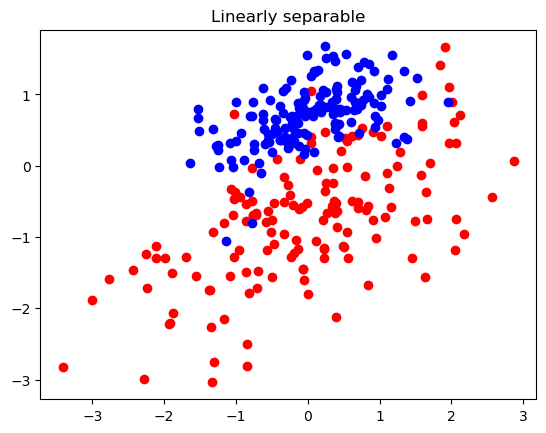

In [55]:
# Generate and visualize linearly separable data
plot_dataset('linearly_separable', 'Linearly separable')

Although this dataset is not linearly separable, a linear classifer would perform relatively well as we can see from a visual inspection. Therefore, a polynomial classifer would perform at least as well.

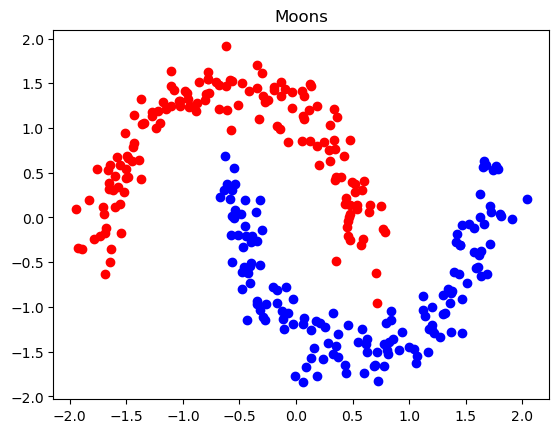

In [56]:
# Generate and visualize moons data set
plot_dataset('moons', 'Moons')

Although the line `y = 0` would perform ok, it's clear that this dataset could use a non-linear classifier to be separated.

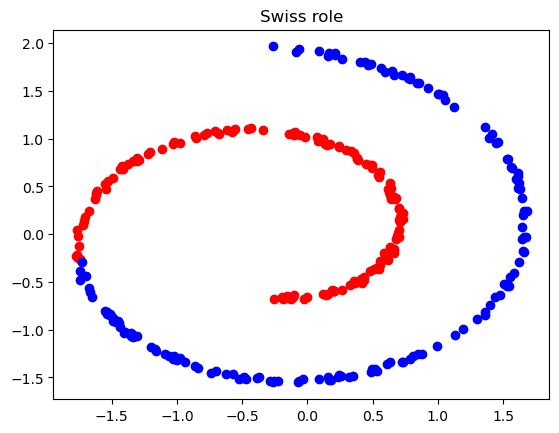

In [57]:
# Generate and visualize swiss role with 2 split sets
plot_dataset('swiss', 'Swiss role', split = 2)

A non-linear classifier could perform quite well, even a polynomial of degree `2` contrary to a linear classifier.

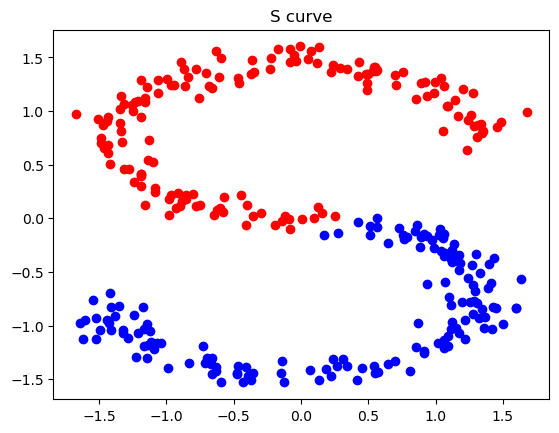

In [58]:
# Generate and visualize S curve with 2 split sets
plot_dataset('scurve', 'S curve', split = 2)

Both linears and non-linears classifier would do a good job. The line going through (-1.5, -1) and the origin seems to almost separate both groups.

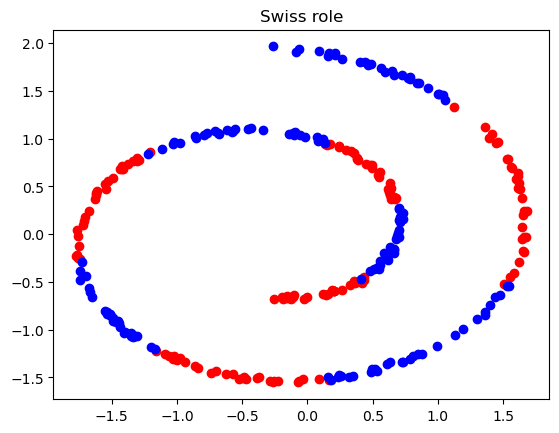

In [59]:
# Generate and visualize swiss role with 10 split sets
plot_dataset('swiss', 'Swiss role', split = 10)

This data set could be classifier quite well by a non-linear classifier of high degree but it any linear classifier would not perform well.

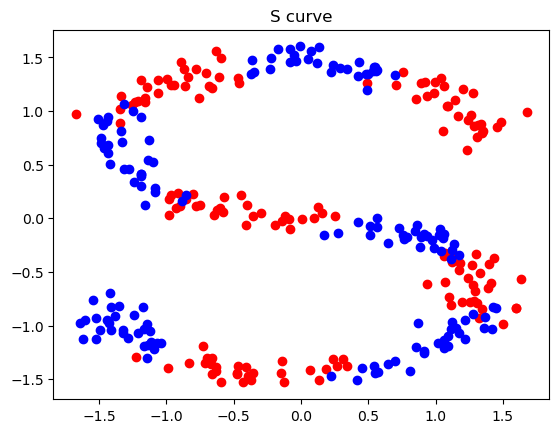

In [60]:
# Generate and visualize S curve with 10 split sets
plot_dataset('scurve', 'S curve', split = 10)

This data set could be classifier quite well by a non-linear classifier of high degree but it any linear classifier would not perform well.

### Part 1.2: SVM with nonlinear kernels

The next cell defines the function `kernel_comparison`, which you can use to visually compare the decision boundaries generated by SVMs with different kernels. 

1. The kernel comparison currently produces only visual results. Add code to the function so that it also outputs train and test accuracy of the different SVMs. (Note: Think carefully about where the right place in the code is to do a train-test split.)
2. Run the kernel comparison for the data sets from Part 1.1. Do the results confirm or contradict your expectations that you formulated in Part 1.1.? Did any of the results surprise you?
3. Consult sklearn's documentation to learn how the keyword arguments `degree` and `gamma` affect your classifier. Try out a few different values of these parameters. How and what can one infer from the shape of the decision boundary about the classifier's `degree` or `gamma`?

In [72]:
def kernel_comparison(X, y, support_vectors=True, tight_box=False, if_flag=False, title=None):
    fig = plt.figure(figsize=(10,3))

    if title:
        fig.suptitle(title)
    
    for ikernel, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        # Train the SVC
        clf = svm.SVC(kernel=kernel, degree=3, gamma=3).fit(X, y)
    
        # Settings for plotting
        ax = plt.subplot(1,4,1+ikernel)
        #x_min, x_max, y_min, y_max = -3, 3, -3, 3
        #ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    
        # Plot decision boundary and margins
        common_params = {"estimator": clf, "X": X, "ax": ax}
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
        '''
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[-1, 0, 1],
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
        )'''
    
        if support_vectors:
            # Plot bigger circles around samples that serve as support vectors
            ax.scatter(
                clf.support_vectors_[:, 0],
                clf.support_vectors_[:, 1],
                s=150,
                facecolors="none",
                edgecolors="k",
            )
    
        # Plot samples by color and add legend
        ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
        ax.set_title(kernel)
        ax.axis('off')
        if tight_box:
            ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
            ax.set_ylim([X[:, 1].min(), X[:, 1].max()])

        '''ADD SOME CODE HERE'''

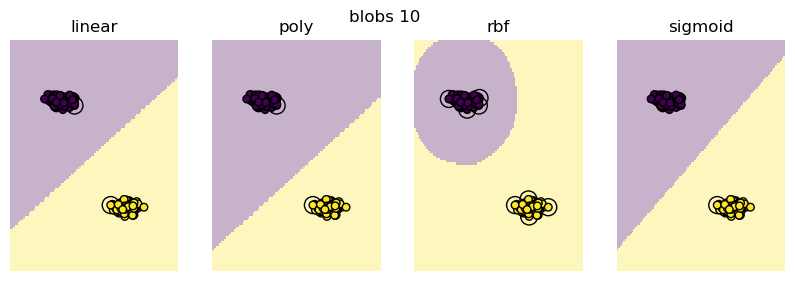

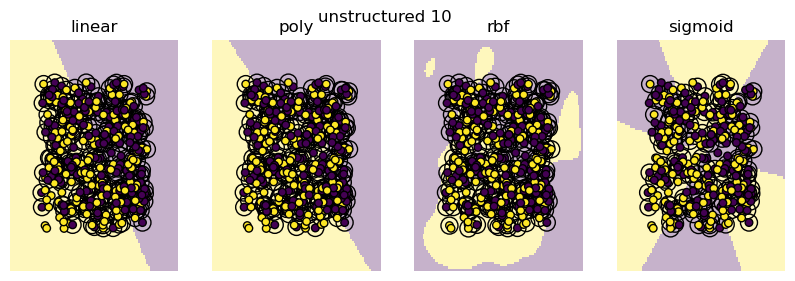

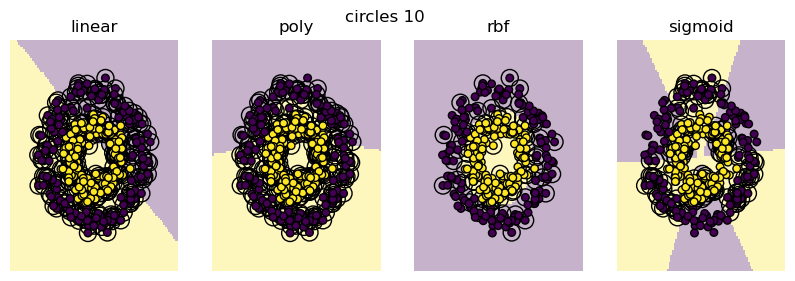

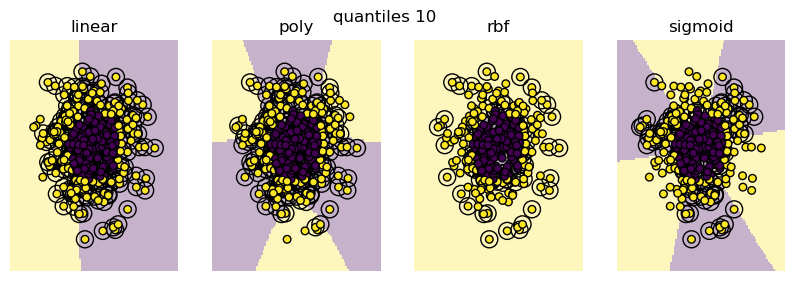

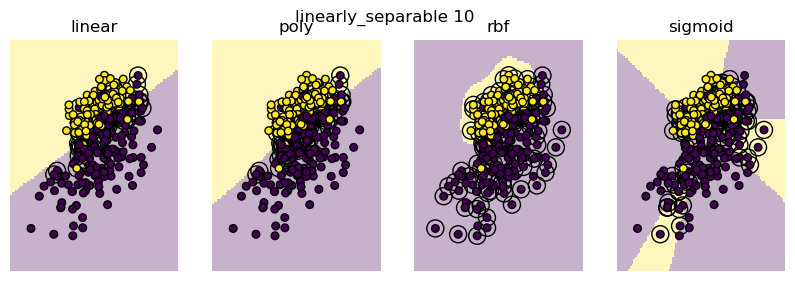

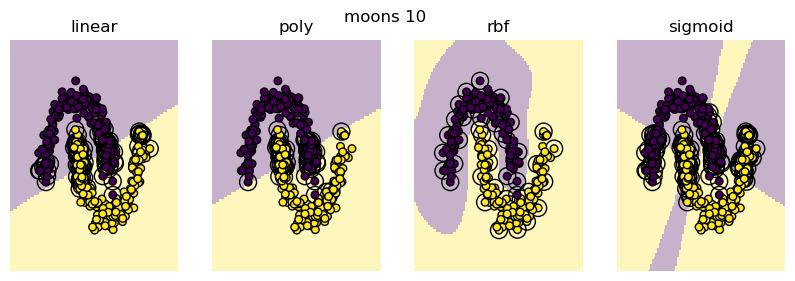

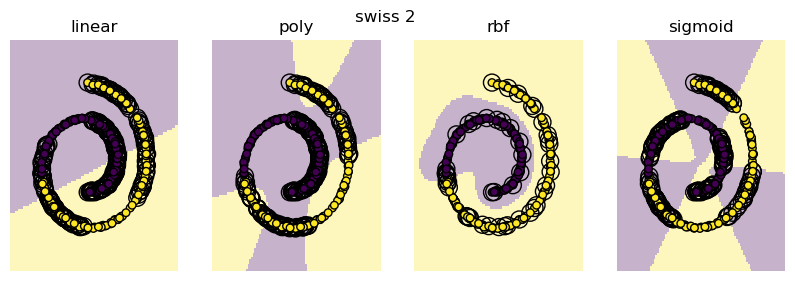

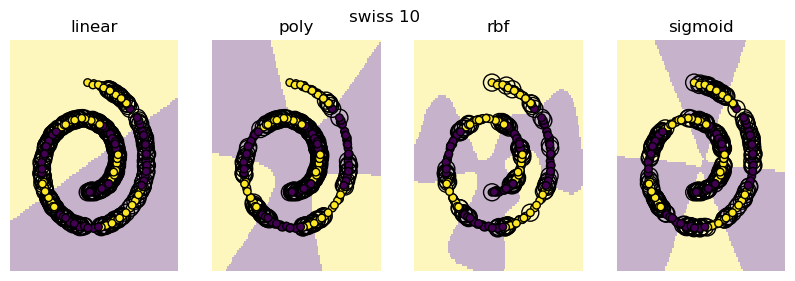

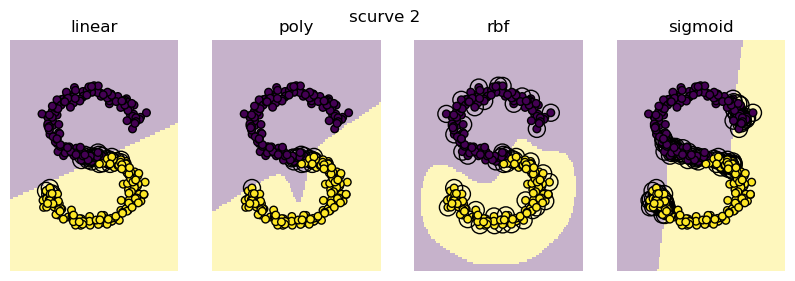

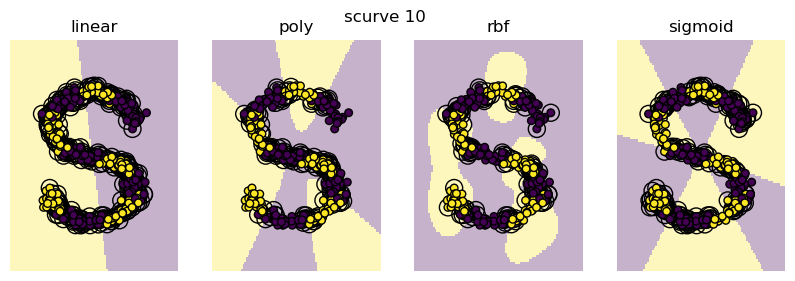

In [76]:
# Show results of kernel comparison for data sets from part 1
types = ['blobs', 'unstructured', 'circles', 'quantiles', 'linearly_separable', 'moons', 'swiss', 'scurve']
split = [[10], [10], [10], [10], [10], [10], [2, 10], [2, 10]]

for i in range(len(types)):
    for j in range(len(split[i])):
        X, y = generate_dataset(types[i], split = split[i][j])
        kernel_comparison(X, y, title = f'{types[i]} {split[i][j]}')

To summarize the results of the kernel comparison, [ADD SOME TEXT HERE]. 

In [63]:
# Examine effect of degree and gamma keyword
'''ADD SOME CODE HERE'''

'ADD SOME CODE HERE'

The `degree` argument affects [ADD NAME OF DATA GENERATION METHOD]. It changes the model by [ADD SOME TEXT HERE]. This affects the model's bias-variance tradeoff by [ADD SOME TEXT HERE]. 

As one increases the `degree`, the decision boundary [ADD SOME TEXT HERE]. 

The `gamma` argument affects [ADD NAME OF DATA GENERATION METHOD]. It changes the model by [ADD SOME TEXT HERE]. This affects the model's bias-variance tradeoff by [ADD SOME TEXT HERE]. 

As one increases `gamma`, the decision boundary of [ADD SOME TEXT HERE]. 


## Part 2: US Flags

### Part 2.1: Load and explore flags data
The function `load_images` loads the image data from the flags folder and turns each image into a binary (i.e., black and white) array.

1. Load the flags data.
2. Display four flags of your choice in a figure. Use the `matplotlib` commands `subplot` and `imshow` to create a figure with 2x2 flags. Consult the `matplotlib` documentation to find a way set the aspect ratio of your displayed flags to match their original aspect ratio. Update your code accordingly.

In [64]:
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert image to black and white
            img = np.array(img)//(256/2) # Convert to BW
            images.append(img)
            labels.append(filename.split('.')[0])  # Extract the state code as label
    return images, labels

In [65]:
# Display four black-and-white flags in a 2x2 grid
'''ADD SOME CODE HERE'''

'ADD SOME CODE HERE'

### Part 2.2: SVMs for flag pixel data
The function `sample_pixels` samples a pixel from a given image uniformly at random. 

1. Use the `sample_pixels`  function to generate synthetic data sets of pixels from for a flag image.
2. Update the `kernel_comparison` function so that if `if_flag` is `True` the decision boundaries are plotted in a 2x2 grid of subplots with plot ranges matching the height and width of the flags.
3. Show the results of the kernel comparison for the four flags that your previously selected. Use the highest values of `degree` and `gamma` that still run *reasonably fast* on your laptop.
4. Adjust your code so that you can run the quantitative part (i.e., the calculation of train and test accuracy) without plotting the decision boundaries. Run the adjusted code on all flags to indentify for each kernel the flags that yield to best easiest-to-classify and hardest-to-classify data sets. Test how the number of of pixels sampled affects your results.

In [66]:
def sample_pixels(image, num_samples=100):
    pixel_data = []
    pixel_labels = []
    height, width = image.shape
    for _ in range(num_samples):
        x1 = random.randint(0, width - 1)
        x2 = random.randint(0, height - 1)
        pixel_data.append([x1/width-0.5, x2/width-0.5])
        pixel_labels.append(image[x2,x1])
    return np.array(pixel_data), np.array(pixel_labels, dtype=int)

In [67]:
# Visual kernel comparison for selected flags
'''ADD SOME CODE HERE'''

'ADD SOME CODE HERE'

In [68]:
# Non-visual kernel comparison for all flags
'''ADD SOME CODE HERE'''

'ADD SOME CODE HERE'

For these experiments, I set `num_samples` to [ADD NUMBER HERE] because the results of the experiments seem to be the most stable for this number of sampled pixels.

The linear kernel performed best (i.e., highest test accuracy) on the flags of the following three states: 

[ADD TOP THREE STATE NAMES HERE]

It performed worst on the flags of the following three states: 

[ADD TOP THREE STATE NAMES HERE]

The polynomial kernel performed best on the flags of the following three states: 

[ADD TOP THREE STATE NAMES HERE]

It performed worst on the flags of the following three states: 

[ADD TOP THREE STATE NAMES HERE]

The radial-basis function kernel performed best on the flags of the following three states: 

[ADD TOP THREE STATE NAMES HERE]

It performed worst on the flags of the following three states: 

[ADD TOP THREE STATE NAMES HERE]

The sigmoid kernel performed best on the flags of the following three states: 

[ADD TOP THREE STATE NAMES HERE]

It performed worst on the flags of the following three states:

[ADD TOP THREE STATE NAMES HERE]

### Part 2.3: Comparison to decision trees
Decision trees and SVMs yield substantially different decision boundaries.

1. An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set. Explain why.
2. For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy as well. Explain why.
3. Select four flags for which you anticipate a *simple* decision tree to outperform all your SVMs. Write code that fits a decision tree to a flag pixel data set. Use your code to check your hypothesis. 

An arbitrarily complex decision tree would be able to achieve perfect training accuracy on any data set, because [ADD SOME TEXT HERE].

For a very large data set of flag pixels, an arbitrarily complex decision tree is likely to achieve (almost) perfect test accuracy because [ADD SOME TEXT HERE].

A simple decision tree is likely to perform well on the sampled pixel data of the flags of [ADD NAMES OF AT LEAST FOUR US STATES HERE].

In [69]:
# Comparison of SVM and decision tree performance on sampled pixel data for four flags

'''ADD CODE HERE'''

'ADD CODE HERE'